In [1]:
import numpy as np # importing numpy for matrix operations 
from scipy import *
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display 
import itertools
from IPython.display import display
import random
import operator
from random import choices, randint, randrange, random, sample, seed, uniform, choice
from collections import namedtuple
from typing import List, Optional, Callable, Tuple
from functools import partial
sns.set()
import random
from itertools import product
import re
from collections import OrderedDict
from operator import getitem
  

In [2]:
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

In [3]:
class MarketConfig: 
    #class attributes
    t0 = 2016 #The starting year for evaluation of the pay-offs
    T = 3#35  # Planning Horizon t = 2016,...,2040 # 100 year scope 
    year = np.arange(2016, 2016 + T)
    distance = np.array([11810]) #nautical miles #Notteboom (2006)  
    port_time =  np.array([264])  #hours ==> 11 days in a year  #Notteboom (2006)
    demand_16_20 = np.array([1303780  for j in range(5)]) #in TEU #placehplder to be calibrated with the chosen route 
    annual_working_time = np.array([6480])  #hours per year, assumption   #hours per year, assumption 
    initial_freight_rate = np.array([1800])  ## in US$/TEU 
    SFOC_main = np.array([206])  #g/kWh, specific daily main engine fuel oil consumption rate
    SFOC_aux = np.array([221]) # specific fuel oil consumption of the auxiliary engine [g/kW h], 
    eng_load_main = np.array([0.8]) # % 
    eng_load_aux = np.array([0.5])  # engine load of the auxiliary engine [\%]


    def __init__(self, number_of_firms, pollution_decay_parameter, pollution_damage_parameter, demand_income_elasticity, demand_price_elasticity, 
                 freight_rate, fuel_data, discount_rate ):
        '''__init__ a method to describe the poperty that the shipping market and simulation game has'''
        self.number_of_firms = number_of_firms
        self.pollution_decay_parameter = pollution_decay_parameter
        self.pollution_damage_parameter = pollution_damage_parameter
        self.demand_income_elasticity = demand_income_elasticity #Constant income elasticity #IMF
        self.demand_price_elasticity =  demand_price_elasticity #Constant own price elasticity#IMF
        self.freight_rate = freight_rate ## in US$/TEU
        self.fuel_data = fuel_data 
        self.discount_rate = discount_rate 
        #self.bau_industry_emission =  bau_industry_emission 
        #self.bau_pollution_stock = bau_pollution_stock
        self.market_capacity = 0 
         
    
    def get_market_capacity (self, firm_instance):
        self.market_capacity += np.multiply(firm_instance.max_number_of_vessel, firm_instance.capacity) 
        return self.market_capacity 
    
    def get_freight_rate_ratio(self):
        self.beta = np.true_divide(self.freight_rate, MarketConfig.initial_freight_rate) 
        return self.beta
   
    def get_market_demand(self):
        '''compute market level demand'''
        #---------> 1.Import real GDP growth data & compute GDP ratio : Source IMF@2020 #
        G_df = pd.read_csv('./data/real_growth_rate.csv') #import IMF data
        #-------> 2.Construct GDP projection path 2016-2050 based on projection growth data 
        gdp_growth= G_df.values[:,1:] 
        g =1 +(gdp_growth/100)  
        self.gdp = np.array([100.00 for j in range(MarketConfig.T)])
        for foo in range (1,MarketConfig.T):
            self.gdp[foo] = g[:,foo]* self.gdp[foo-1]
        #print(self.gdp)
        #--------->  "compute GDP ratio based on IMF@2020"
        gdp_ratio = np.array([1.00 for j in range(MarketConfig.T)])
        for moo in range (1,MarketConfig.T):
            sub_g = g[:,0:moo+1]
            #print(sub_g)
            gdp_ratio[moo] = np.prod(sub_g)
        
        #--------->  "compute freight rate ratio"
        self.freight_rate_ratio_multiplied = np.power(self.beta, self.demand_price_elasticity)
        #print(freight_rate_ratio_multiplied)
        
        #---------> "Project Transport Demand (industry demand)"
        loo =np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), self.freight_rate_ratio_multiplied ) #Will need to be updated in case fuel prices are varied over time  
        self.market_demand = np.multiply(loo, MarketConfig.demand_16_20[0])
        #print(Y) # size = 1 dimesion array with size T=35 years
        self.market_psy = np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), MarketConfig.demand_16_20[0] )
        return self.market_demand, self.gdp, self.market_psy

In [4]:
class Firm:
    #class attributes intialisation, to be updated with the addition of each instance
    _registry = []
    
    def __init__(self, index, capacity, max_number_of_vessel, design_speed, 
                 min_speed, max_speed, main_engine_power, aux_engine_power,
                 fix_cost, fuel_type):
        '''__init__ a method to describe the poperty that all shipping firm have'''
        self._registry.append(self)
        self.index = index
        self.capacity = capacity # Vessel capacity in TEU per firm, 
        self.max_number_of_vessel = max_number_of_vessel # # of vessels per firms
        self.design_speed = design_speed  #design speed of the vessel in knots
        self.min_speed = min_speed #min vessel speed
        self.max_speed = max_speed #max vessel speed         
        self.main_engine_power =  main_engine_power  # PS_m : main engine power in kW
        self.aux_engine_power =  aux_engine_power  # auxiliary engine power [kW] 
        self.fix_cost = fix_cost #Daily cost of vessel (USD/Day) $25,000
        self.fuel_type = fuel_type
        #self.bau_emission = bau_emission
         
   
    # Firm methods 
    def get_market_share(self , market_instance):
        '''return market share of the firm accoding to it s capacity'''
        self.transport_capacity = np.multiply(self.max_number_of_vessel , self.capacity)
        self.market_share= np.true_divide(self.transport_capacity, market_instance.market_capacity)
        return self.market_share
        
    def get_firm_param(self, market_instance):
        self.psy = np.multiply (self.market_share , market_instance.market_psy)
        return self.psy
    
    def get_firm_demand(self, market_instance):
        self.firm_demand = np.multiply (self.market_share , market_instance.market_demand)
        return self.firm_demand 
    
    def update_vessel_speed(self, operational_speed):
        self.operational_speed = operational_speed
        #print(self.operational_speed)
        return self.operational_speed 
    
    def get_min_number_of_vessel(self, market_instance):
        self.time_at_sea = np.true_divide(market_instance.distance,  self.operational_speed) #returns a vector 
        self.voyage_time = self.time_at_sea + market_instance.port_time #returns a vector 
        self.number_of_trips_to_meet_demand = np.true_divide(self.firm_demand, self.capacity) #returns a vector
        self.max_trips_per_vessel = np.true_divide(market_instance.annual_working_time, self.voyage_time) #returns a vector
        self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel) #returns a vector
        return self.min_number_of_vessel_to_meet_demand, self.number_of_trips_to_meet_demand, self.time_at_sea 
    
    def get_number_of_vessel(self):
        self.number_of_vessel = np.ceil(self.min_number_of_vessel_to_meet_demand) #returns a vector
        #print(self.number_of_vessel)
        return self.number_of_vessel
            
    def get_ship_energy_efficiency(self, market_instance):
        self.main_fuel_parameter =np.multiply(np.multiply(np.multiply(market_instance.SFOC_main,market_instance.eng_load_main),self.main_engine_power), 10**(-6))
        #self.main_fuel_parameter = market_instance.SFOC_main * market_instance.eng_load_main * self.main_engine_power * 10**(-6)
        self.ship_energy = np.multiply(self.main_fuel_parameter, np.power(self.design_speed, -3) )      
        return self.ship_energy
        
    def get_main_fuel_cons(self, market_instance):
        self.main_fuel_con= np.multiply(np.multiply(np.multiply(market_instance.distance, self.ship_energy), np.power(self.operational_speed, 2)) , self.number_of_trips_to_meet_demand)
        self.main_fuel_cons = market_instance.distance * self.ship_energy * (self.operational_speed**2) *self.number_of_trips_to_meet_demand
        return self.main_fuel_cons #returns a vector
        
    def get_aux_fuel_cons(self, market_instance): 
        self.aux_fuel_parameter = np.multiply(np.multiply(np.multiply( market_instance.SFOC_aux, market_instance.eng_load_aux), self.aux_engine_power),  10**(-6))
        #self.aux_fuel_parameter = market_instance.SFOC_aux * market_instance.eng_load_aux * self.aux_engine_power * 10**(-6)
        self.aux_fuel_cons =  np.true_divide((self.aux_fuel_parameter * self.number_of_trips_to_meet_demand * market_instance.distance), self.operational_speed)        
        return self.aux_fuel_cons #returns a vector   
    
        
    def get_fuel_cost(self, market_instance):
        self.aux_fuel_cost =np.multiply(self.aux_fuel_cons, market_instance.fuel_data['MGO']['price'])  
        self.main_fuel_cost = np.multiply(self.main_fuel_cons, market_instance.fuel_data[self.fuel_type]['price'])   
        self.fuel_cost = self.main_fuel_cost + self.aux_fuel_cost 
        return self.fuel_cost #returns a vector
    
    
    def get_firm_carbon_emission(self, market_instance):
        self.carbon_aux_emision_factor = market_instance.fuel_data['MGO']['carbon_factor']
        self_carbon_aux_emissions = np.multiply(self.carbon_aux_emision_factor, self.aux_fuel_cons )  
        self.carbon_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['carbon_factor']
        self_carbon_main_emissions =np.multiply(self.carbon_main_emision_factor, self.main_fuel_cons)  
        self_carbon_emissions = self_carbon_main_emissions + self_carbon_aux_emissions 
        return self_carbon_emissions
    
    def get_firm_sulfur_emission(self, market_instance):
        self.sulfur_aux_emision_factor = market_instance.fuel_data['MGO']['sulfur_factor']
        self_sulfur_aux_emissions = np.multiply(self.sulfur_aux_emision_factor, self.aux_fuel_cons)  
        self.sulfur_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['sulfur_factor']
        self_sulfur_main_emissions = np.multiply(self.sulfur_main_emision_factor, self.main_fuel_cons)  
        self_sulfur_emissions = self_sulfur_main_emissions + self_sulfur_aux_emissions 
        return self_sulfur_emissions      
    
            
    def get_total_cost(self):
        self.operating_cost = np.multiply(self.fix_cost, self.number_of_vessel)  #Fixed Cost
        self.total_cost = self.operating_cost + self.fuel_cost
        return self.total_cost #returns a vector    
    
    def update_total_cost(self, total_cost_with_policy):
        self.total_cost = total_cost_with_policy
        return self.total_cost 
                 
    def get_revenue(self,market_instance):
        self.revenue = np.multiply(self.firm_demand, market_instance.freight_rate)
        return self.revenue #returns a vector
    
    def get_period_profits(self):
        self.period_profit = self.revenue - self.total_cost
        return self.period_profit #returns a vector
    
    def get_discounted_period_profit(self,market_instance):
        self.period_index_vector = np.arange(1,MarketConfig.T + 1)
        self.discount_multiplier = np.power( 1+ market_instance.discount_rate, - self.period_index_vector)
        self.discounted_period_profit = np.multiply( self.discount_multiplie, self.period_profit) 
        return self.discounted_period_profit #returns a vector

# Create Firm and Industry Objects: 3 firms and market

In [5]:
####################################### 1. Firm & Market specific Parameters ###########################################
                    #===========================>  Firm 1 Attributes <==========================#
index_1 = 1
capacity_1 = np.array([5905]) 
max_number_of_vessel_1= np.array([100]) 
design_speed_1 = np.array([23.3]) #design speed of the vessel in knots
min_speed_1 = 10
max_speed_1 = 30
main_engine_power_1 =np.array([41186])  # main engine power in kW
aux_engine_power_1 =np.array([2433])  # auxiliary engine power [kW] 
fix_cost_1 = np.array([6750000])   #Daily cost of vessel (USD/Day) $25,000
fuel_type_1 = "HFO"

In [6]:
                    #===========================>  Firm 2 Attributes <==========================#
index_2 = 2
capacity_2 = np.array([6470])
max_number_of_vessel_2 = np.array([100])
design_speed_2 = np.array([24.7])  #design speed of the vessel in knots
min_speed_2 = 10
max_speed_2 = 30
main_engine_power_2 = np.array([56273]) # main engine power in kW
aux_engine_power_2 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_2 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_2 = "HFO"

In [7]:
                    #===========================>  Firm 3 Attributes <==========================#
index_3 = 3
capacity_3 = np.array([6470])
max_number_of_vessel_3 = np.array([100])
design_speed_3 = np.array([24.7])  #design speed of the vessel in knots
min_speed_3 = 10
max_speed_3 = 30
main_engine_power_3 = np.array([56273]) # main engine power in kW
aux_engine_power_3 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_3 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_3 = "HFO"

In [8]:
                    #===========================> Market Attributes <==========================#
number_of_firms = 3
pollution_decay_parameter =  np.array([0.2])
pollution_damage_parameter =  np.array([1.5])
year  = MarketConfig.year
income_elasticity = np.array([0.8]) #Constant income elasticity #IMF
price_elasticity = np.array([-0.7])   #Constant own price elasticity#IMF
freight_rate = np.array([1800]) ## in US$/TEU
fuel_data = pd.DataFrame(np.array([[422.50, 525.50, 597.00], 
                                [3.114,3.206,3.206],
                                [0.07,0.01,0.002]]),
                         columns=['HFO', 'ULSFO', 'MGO'],
                         index = ['price', 'carbon_factor', 'sulfur_factor'])
discount = np.array([0.02])  ##3  to 5 % transport canada ,#to be updated using the Ramsey rule,#pure rate of time preference of 1.5% + growth rate of consumption g * rate of risk conversion , an elasticity value of 2

# Initilise Game and set up Firm and market objects

In [9]:
""" This cell needs to run once throughout the kernel"""
####################################### 2.Simulation Game Initialisation ###########################################
firm_1 = Firm(index_1, capacity_1, max_number_of_vessel_1, design_speed_1, 
                 min_speed_1, max_speed_1, main_engine_power_1, aux_engine_power_1,
                 fix_cost_1, fuel_type_1) 

firm_2 = Firm(index_2, capacity_2, max_number_of_vessel_2, design_speed_2, 
                 min_speed_2, max_speed_2, main_engine_power_2, aux_engine_power_2,
                 fix_cost_2, fuel_type_2) 

firm_3 = Firm(index_3, capacity_3, max_number_of_vessel_3, design_speed_3, 
                 min_speed_3, max_speed_3, main_engine_power_3, aux_engine_power_3,
                 fix_cost_3, fuel_type_3) 



game_config = MarketConfig(number_of_firms, pollution_decay_parameter, pollution_damage_parameter, income_elasticity, price_elasticity, freight_rate, 
                           fuel_data, discount)

####################################### 3.Get market capacity #################################
for  firm_object in Firm._registry:
    market_capacity_sim = game_config.get_market_capacity(firm_object)

# Market Demand

In [10]:
## Get freight ratio for passethrough
beta_sim = game_config.get_freight_rate_ratio()

# Get market demand  
market_demand_sim, gdp_sim, market_psy_sim = game_config.get_market_demand()
print("market demand", market_demand_sim)

# Get each firm's  market share  
firm_1_market_share_sim = firm_1.get_market_share(game_config)
print("firm 1 market share", firm_1_market_share_sim)

firm_2_market_share_sim = firm_2.get_market_share(game_config)
print("firm 2 market share", firm_2_market_share_sim)

firm_3_market_share_sim = firm_3.get_market_share(game_config)
print("firm 3 market share", firm_3_market_share_sim)

market demand [1303780.         1378613.27053661 1417081.19385409]
firm 1 market share [0.31334572]
firm 2 market share [0.34332714]
firm 3 market share [0.34332714]


### Graphing Market Demand:

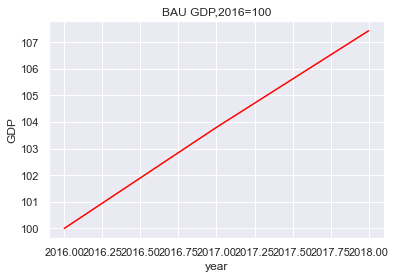

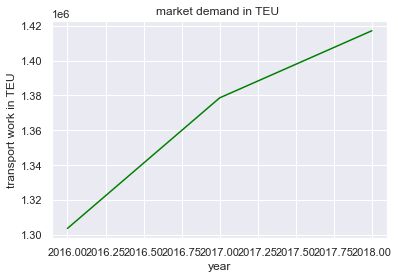

In [11]:
#======> Plotting BAU GDP,2016=100
sns.set()
ax=sns.lineplot(x=year ,y =gdp_sim, color = 'red')
ax.set(xlabel='year', ylabel='GDP')
plt.title("BAU GDP,2016=100" )
plt.show()

#======> Plotting Market Demand Projections in BAU senario: Y
ax=sns.lineplot(x=year ,y = market_demand_sim, color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("market demand in TEU " )
plt.show()

#======> Plotting Marketshare per firm



## a. Firm 1:

In [12]:
 # 7.Get firm passthrough parameter
firm_1_psy_sim = firm_1.get_firm_param(game_config)

# 7.Get firm level demand  
firm_1_demand_sim = firm_1.get_firm_demand(game_config)
print("firm 1 demand", firm_1_demand_sim)
    
# 9.Get ship energy efficiency  
firm_1_ship_energy_sim = firm_1.get_ship_energy_efficiency(game_config)
print("firm 1 ship energy", firm_1_ship_energy_sim)

firm 1 demand [408533.87635978 431982.56102514 444036.3199633 ]
firm 1 ship energy [0.00053659]


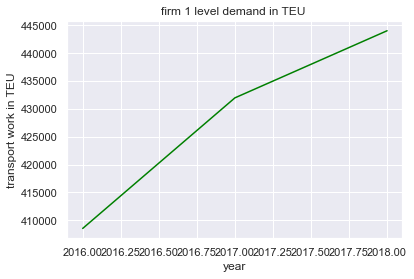

In [13]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_1_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 1 level demand in TEU " )
plt.show()

## b. Firm 2

In [14]:
# 7.Get firm passthrough parameter
firm_2_psy_sim = firm_2.get_firm_param(game_config)

# 7.Get firm level demand  
firm_2_demand_sim = firm_2.get_firm_demand(game_config)
print("firm 2 demand", firm_2_demand_sim)


# 9.Get ship energy efficiency  
firm_2_ship_energy_sim = firm_2.get_ship_energy_efficiency(game_config)
print("firm 2 ship energy", firm_2_ship_energy_sim)

firm 2 demand [447623.06182011 473315.35475574 486522.4369454 ]
firm 2 ship energy [0.00061541]


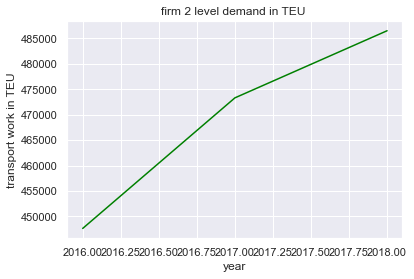

In [15]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_2_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 2 level demand in TEU " )
plt.show()

## c. Firm 3

In [16]:
# 7.Get firm passthrough parameter
firm_3_psy_sim = firm_3.get_firm_param(game_config)

# 7.Get firm level demand  
firm_3_demand_sim = firm_3.get_firm_demand(game_config)
print("firm 3 demand", firm_3_demand_sim)


# 9.Get ship energy efficiency  
firm_3_ship_energy_sim = firm_3.get_ship_energy_efficiency(game_config)
print("firm 3 ship energy", firm_3_ship_energy_sim)

firm 3 demand [447623.06182011 473315.35475574 486522.4369454 ]
firm 3 ship energy [0.00061541]


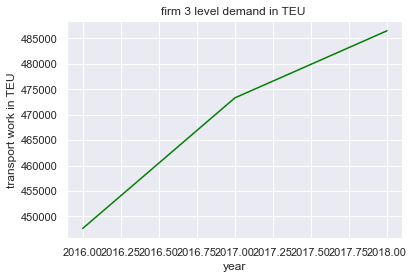

In [17]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_3_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 3 level demand in TEU " )
plt.show()

# COEV  Set up 

## Insert Here

### Object Init

In [18]:
#====> Iinitialisation of chromo and population objects 
Chromo = List[float] 
Population = List[Chromo]  

### callable functions declaration

In [19]:
#====> Iinitialisation of function objects; Define the Objects; They allow you to pass in only what you need during the evol function 
PopulateFunc = Callable[[], Population]
VesselProc = Callable[[Chromo, Firm], Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray , np.ndarray ,np.ndarray, np.ndarray, np.ndarray]]
Best_Partner_And_Fitness_Func = Callable[[Chromo,int, int, Firm, dict] , dict]  
    
SelectionFunc = Callable[[np.ndarray, np.ndarray], Tuple[Chromo, Chromo]]  #takes a population and a fitness fn to select 2 solutions to be the parents of our next generaation solution
CrossoverFunc = Callable[[Chromo, Chromo], Tuple[Chromo, Chromo]] #takes 2 genomes and returns 2 new genomes 
MutationFunc = Callable[[Chromo], Chromo] #takes 1 genome and sometimes returns a modified one
#FitnessFunc = Callable[[Chromo], Tuple[float, int, float, float]] #int to refelct max # of vessel


In [20]:
#======>
def generate_chromo(firm: Firm, vessel_proc: VesselProc) :
    while True:
        chromo = np.random.uniform(firm.min_speed, firm.max_speed, MarketConfig.T )  
        if (vessel_proc(chromo, firm)[0] != 0).all():
            break
        #print("chromo", chromo)
    return chromo  

#======>
def generate_population(vessel_proc: VesselProc, 
                        firm:Firm, 
                        size: int ):
    return  np.array([generate_chromo(firm, vessel_proc) for _ in range(size)])

#=====>
def selection_pair (chromo, weights):  
    selected_index = np.random.choice(np.arange(9),size = 2, replace=False,p= weights)
    return chromo[selected_index[0]],chromo[selected_index[1]]

#=======>
def BLX_alpha_crossover (a: Chromo, b: Chromo, firm :Firm, sim_game) :
    child = np.zeros(sim_game.T)
    lower = np.zeros(sim_game.T)
    upper = np.zeros(sim_game.T)
    for i in range(sim_game.T): 
        lower[i] = (min(a[i],b[i])) - ( (0.5) * (max(a[i],b[i]) - min (a[i],b[i])))
        upper[i] = (max(a[i],b[i])) + ( (0.5) * (max(a[i],b[i]) - min (a[i],b[i])))
        lower[i] = firm.min_speed if (lower[i] < firm.min_speed) else lower[i]
        upper[i]= firm.max_speed if (upper[i] > firm.max_speed) else upper[i]
        child[i] = np.random.uniform (lower[i], upper[i])
    
    return child

#=====>
def mutation(mutated_chromo: Chromo, firm: Firm, sim_game, variance: float, probability: float = 0.5 ) : 
    mutated_chromo = np.zeros(sim_game.T)
    for i in range(sim_game.T): 
        mutated_chromo[i] = np.random.normal(mutated_chromo[i], variance, 1) if random.random() > probability else mutated_chromo[i]
        mutated_chromo[i] = firm.min_speed  if mutated_chromo[i] < firm.min_speed  else mutated_chromo[i]
        mutated_chromo[i] = firm.max_speed if mutated_chromo[i] > firm.max_speed else mutated_chromo[i]
        return mutated_chromo

In [21]:
def vessel_operation_procedure (chromo: Chromo, 
                                firm: Firm, 
                                sim_game: MarketConfig): 
    
    operational_speed_ = firm.update_vessel_speed(chromo)     
    
    min_number_vessels_sim , trips_to_meet_demand_sim, time_at_sea_sim  = firm.get_min_number_of_vessel(sim_game)
    #print(min_number_vessels_sim)
    number_vessels_sim  = firm.get_number_of_vessel()
    #print("max_number_of_vessel", firm.max_number_of_vessel)
    #print("number_vessels_sim", number_vessels_sim)
    
    if (number_vessels_sim > firm.max_number_of_vessel).any():
        #true 
        return np.zeros(9) #np.array([0,..,0])
    else:
        main_fuel_con_sim = firm.get_main_fuel_cons(sim_game)
        #print("main_fuel_con_sim", main_fuel_con_sim)
        aux_fuel_con_sim = firm.get_aux_fuel_cons(sim_game)
        #print("aux_fuel_con_sim", aux_fuel_con_sim)
        fuel_cost_sim = firm.get_fuel_cost(sim_game) 
        #print("fuel_cost_sim", fuel_cost_sim)
        total_cost_sim = firm.get_total_cost()
        #print("total_cost_sim", total_cost_sim)
        revenue_sim = firm.get_revenue(sim_game)
        #print("revenue_sim", revenue_sim)
        profit_vector_sim = firm.get_period_profits()
        #print("profit_vector_sim", profit_vector_sim)
                        
        carbon_emissions_sim = firm.get_firm_carbon_emission(sim_game) 
        #print("carbon_emissions_sim", carbon_emissions_sim)
        sulfur_emissions_sim = firm.get_firm_sulfur_emission(sim_game)
        #print("sulfur_emissions_sim", sulfur_emissions_sim)
    return number_vessels_sim, main_fuel_con_sim, aux_fuel_con_sim, fuel_cost_sim, total_cost_sim , revenue_sim ,profit_vector_sim, carbon_emissions_sim, sulfur_emissions_sim


In [22]:
def getNPV(elem):
    return elem["NPV"]

In [23]:
def best_partner_selection_and_fitness_evaluation (vessel_proc : VesselProc, 
                                                   selected_chromo, 
                                                   selected_chromo_row_loc,
                                                   selected_chromo_column_loc, 
                                                   evolving_species, 
                                                   symbiotic_species, 
                                                   symbiotic_population,
                                                   sim_game, 
                                                   pop_grid_reshape_size,
                                                   carbon_pollution_decay_parameter,
                                                   sulfur_pollution_decay_parameter,
                                                   carbon_pollution_damage_parameter,
                                                   sulfur_pollution_damage_parameter,
                                                   initial_carbon_tax_sim ,
                                                   initial_sulfur_tax_sim ,
                                                   taxation_scheme_rate_sim) :

    #chromo
    #
    discount_multiplier = np.power( 1+ sim_game.discount_rate, - np.arange(1,MarketConfig.T + 1))
    
    
                
                
          

    #==========================================#
    # evolving chromo
    #==========================================#
    #initilise dict results for every chromo for the evolving firm 
    #print("evolving_species is :", evolving_species.index) 
    evolving_firm_vessel_operations = vessel_proc (selected_chromo,evolving_species)

    evolving_species_sim = {}
    evolving_species_sim ["selected_chromo"] = selected_chromo     
    evolving_species_sim ["number_vessels_sim"] =  evolving_firm_vessel_operations[0]
    evolving_species_sim["main_fuel_con_sim"] =  evolving_firm_vessel_operations[1]
    evolving_species_sim["aux_fuel_con_sim"] =  evolving_firm_vessel_operations[2]
    evolving_species_sim["fuel_cost_sim"] =  evolving_firm_vessel_operations[3] 
    evolving_species_sim ["total_cost_sim"] =  evolving_firm_vessel_operations[4]
    evolving_species_sim ["revenue_sim"] =  evolving_firm_vessel_operations[5]  
    evolving_species_sim["profit_vector_sim"]=  evolving_firm_vessel_operations[6]
    evolving_species_sim ["carbon_emissions"] =  evolving_firm_vessel_operations[7] 
    evolving_species_sim["sulfur_emissions"] =  evolving_firm_vessel_operations[8]
    
    #print("evolving_species_sim dict is" , evolving_species_sim) #pd.DataFrame(evolving_species_sim)
    
    
    
    carbon_emissions_sim = {}
    sulfur_emissions_sim = {}
    
    #==========================================#
    # Symbiotic firms
    #==========================================#
    symbiotic_neighberhood ={}
    candidate_partner_chromo = {}
    #print(symbiotic_population)
    #Select candidate partner firms chromos on the grid based on chromo location 3x3 neighberhood  
    for _ in (symbiotic_species):
        #print("row is" ,selected_chromo_row_loc)
        #print("column is" ,selected_chromo_column_loc)
        #reshape population 
        firm_symbiotic_pop = symbiotic_population["firm" + str(_.index)].reshape(pop_grid_reshape_size,
                                                                                 pop_grid_reshape_size,
                                                                                 MarketConfig.T)
        #print("firm_symbiotic_pop", firm_symbiotic_pop)
        #get selection range for the neighberhood selection
        neighberhood_row_selection_range = range(selected_chromo_row_loc - 1, selected_chromo_row_loc + 2 )
        neighberhood_column_selection_range = range(selected_chromo_column_loc - 1, selected_chromo_column_loc + 2 )

        #print("neighberhood_selection_range", neighberhood_row_selection_range, neighberhood_column_selection_range)
        
        #get symbiotic neighberhood 
        # 3: Set  up the Neighberhood N_mn structure for the evolution process based on the selected chromo location
         #For the localized coevolution, a structure of 3 × 3 neighborhood is used for the localized coevolution.
         ##Toroidal_grids (ST): are  the scope of an evolving neighborhood (EN) """
         # Example:  Nmn: 3x3 neighbors of the chromosomes  (3,3)  
        # 5: Set  up the Neighberhood for the sympioses firm SN_mn[l]
        # SNmn[l]: the neighborhood including individual (m,n) and its eight neighbors in the sympioses  firm  pop
        # these are candidate partners for the fitness evaluation: 
        # these are  Chromo @ the same positions in the population of the other firms
        #Once chromo@ (3,3) of evolving firm 2 is selected as the initial point for the evolution, 
         #====> the neighborhoods of the arbitrary symbiotic speicies (SN= Nmn ) are identified.  
        
 
    
        symbiotic_neighberhood= firm_symbiotic_pop.take(neighberhood_row_selection_range,
                                                        mode='wrap',
                                                        axis = 0).take(neighberhood_column_selection_range,
                                                                       mode='wrap',
                                                                       axis=1) 
        #print("symbiotic_neighberhood", symbiotic_neighberhood)
        
        #reshape the neighberhood into 9 partner candidiate  
        candidate_partner = np.reshape(symbiotic_neighberhood, (9, MarketConfig.T )) #(l*m, n)
        
        #print("candidate_partner:", candidate_partner)
        #A dict of the selected candidate partner chromos; 9 chromos for each firm  
        candidate_partner_chromo["firm" + str(_.index)] = candidate_partner
        
        #Get candidate partner (symbiotic firms) period emission level based on their chromo
        carbon_emissions_sim["firm" + str(_.index)] ={}
        sulfur_emissions_sim["firm" + str(_.index)] = {}
        for i in range(9):
            symbiotic_firm_vessel_operations = vessel_proc (candidate_partner_chromo["firm" + str(_.index)][i], _)
            carbon_emissions_sim["firm" + str(_.index)] ["_chromo" + str(i)] =  symbiotic_firm_vessel_operations[7] 
            sulfur_emissions_sim["firm" + str(_.index)] ["_chromo" + str(i)] =  symbiotic_firm_vessel_operations[8]
        #print("####")
            
    #print("carbon_emissions_sim" , carbon_emissions_sim)
    #print("sulfur_emissions_sim", sulfur_emissions_sim)
    
    #==================================================
    #  Carbon industry emissions  
    #==================================================
    #get all possible combination o
    industry_carbon_emission_combo = [dict(zip(carbon_emissions_sim.keys(), a)) for a in itertools.product(*carbon_emissions_sim.values())]
    for _ in range(len(industry_carbon_emission_combo)):
        for firm in industry_carbon_emission_combo[_].keys():
            industry_carbon_emission_combo[_].update({str(firm): {str(industry_carbon_emission_combo[_][str(firm)]): 
                                 carbon_emissions_sim[str(firm)][str(industry_carbon_emission_combo[_][str(firm)])]}})


    firms = tuple(industry_carbon_emission_combo[0].keys())
    
    #Compute industry level carbon emission in each period 
    for _ in range(len(industry_carbon_emission_combo)):
        industry_carbon_emission_combo[_]["industry_carbon_emission"] = evolving_species_sim ["carbon_emissions"]  #0
        for firm in firms:
            chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
            industry_carbon_emission_combo[_]["industry_carbon_emission"] += np.array(industry_carbon_emission_combo[_].get(str(firm)).get(str(chromos[0])))


    #==================================================
    #  Sulfur industry emission 
    #==================================================
      #get all possible combination o
    industry_sulfur_emission_combo = [dict(zip(sulfur_emissions_sim.keys(), a)) for a in itertools.product(*sulfur_emissions_sim.values())]
    for _ in range(len(industry_sulfur_emission_combo)):
        for firm in industry_sulfur_emission_combo[_].keys():
            industry_sulfur_emission_combo[_].update({str(firm): {str(industry_sulfur_emission_combo[_][str(firm)]): 
                                 sulfur_emissions_sim[str(firm)][str(industry_sulfur_emission_combo[_][str(firm)])]}})


    firms = tuple(industry_sulfur_emission_combo[0].keys())
    
    #Compute industry level sulfur emission in each period 
    for _ in range(len(industry_sulfur_emission_combo)):
        industry_sulfur_emission_combo[_]["industry_sulfur_emission"] = evolving_species_sim ["sulfur_emissions"]# 0
        for firm in firms:
            chromos, firm_sulfur_emission = zip(*industry_sulfur_emission_combo[_][str(firm)].items())
            industry_sulfur_emission_combo[_]["industry_sulfur_emission"] += np.array(industry_sulfur_emission_combo[_].get(str(firm)).get(str(chromos[0])))




    
    #==================================================
    #  Carbon policy cost and pollution stock and damages
    #==================================================
    #fitness of the chromo : 
    for _ in range(len(industry_carbon_emission_combo)):
        industry_carbon_emission_combo[_]["carbon_pollution_stock"] =np.zeros (MarketConfig.T)
        industry_carbon_emission_combo[_]["industry_carbon_damages"]= np.zeros (MarketConfig.T)
        industry_carbon_emission_combo[_]["carbon_dynamic_tax"]  = np.zeros (MarketConfig.T)
        industry_carbon_emission_combo[_]["carbon_dynamic_tax"][0]  = initial_carbon_tax_sim    
        for my_period_index in range (MarketConfig.T-1): 
            #Remove and multipy instead of using loop 
            print("this is a problem ")
            industry_carbon_emission_combo[_]["carbon_pollution_stock"] [my_period_index + 1] = (1- carbon_pollution_decay_parameter ) * industry_carbon_emission_combo[_]["carbon_pollution_stock"][my_period_index ] + industry_carbon_emission_combo[0]["industry_carbon_emission"][my_period_index]
            industry_carbon_emission_combo[_]["carbon_dynamic_tax"] [my_period_index+1] = initial_carbon_tax_sim + taxation_scheme_rate_sim * industry_carbon_emission_combo[_]["carbon_pollution_stock"][my_period_index +1 ]


        industry_carbon_emission_combo[_]["industry_carbon_damages"] = 0.5* carbon_pollution_damage_parameter * np.power( industry_carbon_emission_combo[_]["carbon_pollution_stock"],2)

        #Policy and Update Cost 
        #print("carbon tax", industry_carbon_emission_combo[_]["carbon_dynamic_tax"])
        #print("emissions",evolving_species_sim ["carbon_emissions"])
        industry_carbon_emission_combo[_]["carbon_policy_cost"] = np.multiply(evolving_species_sim ["carbon_emissions"], 
                                                                    industry_carbon_emission_combo[_]["carbon_dynamic_tax"]) # a numpy vectore

        
        
    #==================================================
    #  sulfur policy cost and pollution stock and damages
    #==================================================
    for _ in range(len(industry_sulfur_emission_combo)):
        industry_sulfur_emission_combo[_]["sulfur_pollution_stock"] =np.zeros (MarketConfig.T)
        industry_sulfur_emission_combo[_]["industry_sulfur_damages"]= np.zeros (MarketConfig.T)
        industry_sulfur_emission_combo[_]["sulfur_dynamic_tax"]  = np.zeros (MarketConfig.T)
        industry_sulfur_emission_combo[_]["sulfur_dynamic_tax"][0]  = initial_sulfur_tax_sim
    
        for my_period_index in range (MarketConfig.T-1): 
            #Remove and multipy instead of using loop 
            industry_sulfur_emission_combo[_]["sulfur_pollution_stock"] [my_period_index + 1] = (1- sulfur_pollution_decay_parameter ) * industry_sulfur_emission_combo[_]["sulfur_pollution_stock"][my_period_index ] + industry_sulfur_emission_combo[0]["industry_sulfur_emission"][my_period_index]
            industry_sulfur_emission_combo[_]["sulfur_dynamic_tax"] [my_period_index+1] = initial_sulfur_tax_sim + taxation_scheme_rate_sim * industry_sulfur_emission_combo[_]["sulfur_pollution_stock"][my_period_index +1 ]


        industry_sulfur_emission_combo[_]["industry_sulfur_damages"] = 0.5* sulfur_pollution_damage_parameter * np.power( industry_sulfur_emission_combo[_]["sulfur_pollution_stock"],2)

        #Policy and Update Cost 
        industry_sulfur_emission_combo[_]["sulfur_policy_cost"] = np.multiply(evolving_species_sim ["sulfur_emissions"], 
                                                                    industry_sulfur_emission_combo[_]["sulfur_dynamic_tax"]) # a numpy vectore

        
       
    
    #Update chromo for carbon
    for _ in range(len(industry_carbon_emission_combo)):
        for firm in firms:
            chromos, chromo_tobe_updated = zip(*industry_carbon_emission_combo[_][str(firm)].items())
            industry_carbon_emission_combo[_][str(firm)][str(chromos[0])] = candidate_partner_chromo[str(firm)][int(re.findall(r'\d+', chromos[0])[0])]
    
    #Update chromo for sulfur
    for _ in range(len(industry_sulfur_emission_combo)):
        for firm in firms:
            chromos, chromo_tobe_updated = zip(*industry_sulfur_emission_combo[_][str(firm)].items())
            industry_sulfur_emission_combo[_][str(firm)][str(chromos[0])] = candidate_partner_chromo[str(firm)][int(re.findall(r'\d+', chromos[0])[0])]

    
    #Combine dict 
    pollution_analysis = [{**a, **b} for a, b in zip(industry_carbon_emission_combo, industry_sulfur_emission_combo)]
    
    #add pollution cost 
        
    for _ in range(len(pollution_analysis)):
        pollution_analysis[_]["policy_cost"] = pollution_analysis[_]["carbon_policy_cost"]+ pollution_analysis[_]["sulfur_policy_cost"] 
        pollution_analysis[_]["period_profit"] = evolving_species_sim["profit_vector_sim"] -  pollution_analysis[_]["policy_cost"]
        pollution_analysis[_]["discounted_period_profit"]=  np.multiply( discount_multiplier,pollution_analysis[_]["period_profit"]  ) 
        pollution_analysis[_]["NPV"]= np.sum(pollution_analysis[_]["discounted_period_profit"])
        pollution_analysis[_]["chromo evaluated "] = selected_chromo

    integrated_solution_list = sorted(pollution_analysis, key=getNPV, reverse = True )
    
    return integrated_solution_list[0]

In [ ]:
#=====>
def selection_pair (chromo, weights):  
    selected_index = np.random.choice(np.arange(9),size = 2, replace=False,p= weights)
    return chromo[selected_index[0]],chromo[selected_index[1]]

#=======>
def BLX_alpha_crossover (a: Chromo, b: Chromo, firm :Firm, sim_game) :
    minimum_speed = firm.min_speed
    maximum_speed = firm.max_speed
    child = np.zeros(sim_game.T)
    lower = np.zeros(sim_game.T)
    upper = np.zeros(sim_game.T)
    for i in range(sim_game.T): 
        lower[i] = (min(a[i],b[i])) - ( (0.5) * (max(a[i],b[i]) - min (a[i],b[i])))
        upper[i] = (max(a[i],b[i])) + ( (0.5) * (max(a[i],b[i]) - min (a[i],b[i])))
        lower[i] = minimum_speed if (lower[i] < minimum_speed) else lower[i]
        upper[i]= maximum_speed if (upper[i] > maximum_speed) else upper[i]
        child[i] = np.random.uniform (lower[i], upper[i])
    
    return child

#=====>
def mutation(chromo: Chromo, chromo_lower_bound: float, chromo_upper_bound: float
             , variance: float, probability: float = 0.5 ) : 
        chromo = np.random.normal(chromo, variance, 1) if random.random() > probability else chromo
        chromo = chromo_lower_bound if chromo <chromo_lower_bound else chromo
        chromo =chromo_upper_bound if chromo > chromo_upper_bound else chromo
        return chromo

In [24]:
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = 0
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = 1
    return result

In [25]:
def Coevo_GA(populate_func: PopulateFunc,
             vessel_proc: VesselProc,             
             best_partner_and_fitness_func: Best_Partner_And_Fitness_Func,  
             mutation_func: MutationFunc,
             pop_grid_reshape_size,
             sim_game,
             generation_limit,
             selection_func: SelectionFunc = selection_pair,
             crossover_func: CrossoverFunc = BLX_alpha_crossover):
    
    #I.Initialise population :
    #1.Initilise population for each player and map population into a 2x2 lattice ; each chromo must have T genes 
    #2.map The population of each player into toroidal grids 
      # each population represents the coevolving solution communicating with other population,
     #Each of the populations forms a two-dimensional structure of toroidal square lattic
    #result :  3 population 
    Initial_population = {}
    Initial_toroidal_grid_population_format = {}
    #generate population
    for firm_object in (Firm._registry):
        Initial_population["firm" + str(firm_object.index)] = (populate_func(vessel_proc,firm_object))
        Initial_toroidal_grid_population_format["firm" + str(firm_object.index)] = Initial_population["firm" + str(firm_object.index)].reshape(pop_grid_reshape_size,
                                                                                              pop_grid_reshape_size,
                                                                                              MarketConfig.T)#(sqrt(pop size) , sqrt(pop size), #of periods )
     
    #II. Initial fitness evaluation and Identify f_best integrated solution  per firm : 
    Initial_fitness_evaluation ={}
    Initial_symbiotic_population = {}
    for firm_object in (Firm._registry): 
        Initial_fitness_evaluation["firm" + str(firm_object.index)]={}
        Initial_evolving_species = firm_object
        Initial_symbiotic_species = [ _ for _ in Firm._registry if _ != Initial_evolving_species]
        Initial_evolving_population = Initial_population["firm" +  str(Initial_evolving_species.index)]
        
        for _ in (Initial_symbiotic_species):
            Initial_symbiotic_population["firm" + str(_.index)] = Initial_population["firm" + str(_.index)]
        
        Initial_row_loc = -1
        for chromo_to_b_eval in Initial_toroidal_grid_population_format["firm" + str(firm_object.index)]:  
            Initial_row_loc = Initial_row_loc + 1 
            for split in range(pop_grid_reshape_size):
                #get the chromos from the pop
                Initial_selected_chromo = chromo_to_b_eval[split]
                Initial_column_loc = split % pop_grid_reshape_size #mod  ;4
                
                Initial_fitness_evaluation["firm" + str(firm_object.index)]["chromo"+str(Initial_row_loc)+str(Initial_column_loc)] = best_partner_and_fitness_func (vessel_proc, 
                                                                                                                                                    Initial_selected_chromo,
                                                                                                                                                    Initial_row_loc,
                                                                                                                                                    Initial_column_loc, 
                                                                                                                                                    Initial_evolving_species, 
                                                                                                                                                    Initial_symbiotic_species,
                                                                                                                                                    Initial_symbiotic_population)
    
 
    
    
     #III. Seperate the dicts and sort population and find f_best
    Initial_sorted_population = {}
    Initial_f_best ={}
    for firm_object in (Firm._registry): 
        Initial_sorted_population["firm" +str(firm_object.index)] = OrderedDict(sorted(Initial_fitness_evaluation["firm" + str(firm_object.index)].items(),key = lambda x: getitem(x[1], 'NPV'), reverse = True))
        Initial_f_best["firm" +str(firm_object.index)] = Initial_sorted_population['firm'+str(firm_object.index)][str(list(Initial_sorted_population['firm'+str(firm_object.index)].keys())[0])]['NPV']
        #could add fbest chromo
      
    
     #IV. Start the Coev loop
    # Run the coevolutionnary loop / the evolution of populations:While one population evolves, it interacts with the other population. 
    #while (number_of_generation < generation_limit) or (chromo_deviation_chech() > deviation_threshold);
        # the coevolving process runs for a predefined number of generations:
        # the deviation of the chromosome for each species is smaller than the pre-specified threshold, ψ) == false:
 
    fitness_threshold_deviation =  np.array([10000000000000000000]*sim_game.number_of_firms)
    generation_number = 0
    f_best= {} 
    sorted_Updated_fitness_evaluation ={}
    for firm_index in (Firm._registry): 
        f_best["firm" +str(firm_object.index)]  ={}
        sorted_Updated_fitness_evaluation ["firm" +str(firm_object.index)]  ={}
        
    #(fitness_threshold_deviation > [0.1]).any() and
    while (generation_number < generation_limit ) :
#          next_generation = population[0:2]    
        #fbest vector for each firm is no longer changing or genertation threshold
        #Step 1: Neighberhood construction 
        #a) randomy select a random firm h, the evolving spiecies
        evolving_species = random.choice(Firm._registry)
        #to be updated % #number of firms to make sure that each firm is processed each time 
        
        #b) identify the symbiotic spiecies
        symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species]
        
        #c) evolving population 
        evolving_population = Initial_toroidal_grid_population_format["firm" + str(evolving_species.index)]
        
        #d)symbiotic population
        symbiotic_population = {}
        for _ in (symbiotic_species):
                symbiotic_population["firm" + str(_.index)] = Initial_toroidal_grid_population_format["firm" + str(_.index)]
     

        # e) Select an arbitrary location (m,n) from toroidal grids for firm h 
         #for which a neighborhood will be defined for the evolution process#Scope_of_Partners_Toroidal_grids_ST()
        arbitrary_row_loc = randrange(pop_grid_reshape_size) 
        arbitrary_column_loc =  randrange(pop_grid_reshape_size)
        
        
        #f) Identify the corrosponding chromo of the evolving firm "" chromo(m,n)" " as the center of evolution 
             # """chromo@ (3,3) of firm 2 is selected as the initial point for the evolution """
        intial_point_of_evolution = Initial_toroidal_grid_population_format["firm" + str(evolving_species.index)][arbitrary_row_loc,
                                                                                    arbitrary_column_loc]
        
        
         #g). Set  up the Evolving Neighberhood from the evolving firm EN_mn[h]
        # EN_mn[h]: the neighborhood including chromo @location (m; n) and its 8 neighbors in the evolving firm pop Pop[h]
        #Once chromo@ (3,3) of evolving firm 2 is selected as the initial point for the evolution, 
            #==> the neighborhoods of the evolving speicies (EN=N_mn) of the selected chromosome is identifies
            # these 9 chromos are selcted from the chosen firm's population 
            #  These are candidate partners for the fitness evaluation,  Chromo @ the same positions in the population of the other firms
                #print("firm_symbiotic_pop", firm_symbiotic_pop)
        
        #get selection range for the neighberhood selection
        neighberhood_row_selection_range = range(arbitrary_row_loc - 1, arbitrary_row_loc + 2 )
        neighberhood_column_selection_range = range(arbitrary_column_loc - 1, arbitrary_column_loc + 2 )
        
        
        #e) get Evolving Neighberhood
        # 3: Set  up the Neighberhood N_mn structure for the evolution process based on the selected chromo location
         #For the localized coevolution, a structure of 3 × 3 neighborhood is used for the localized coevolution.
         ##Toroidal_grids (ST): are  the scope of an evolving neighborhood (EN) """
         # Example:  Nmn: 3x3 neighbors of the chromosomes  (3,3)  
        evolving_neighberhood= evolving_population.take(neighberhood_row_selection_range,
                                                        mode='wrap',
                                                        axis = 0).take(neighberhood_column_selection_range,
                                                                       mode='wrap',
                                                                       axis=1) 
        
        #get canidiate evolving chromos 
        EN_chromo = np.reshape(evolving_neighberhood, (9, MarketConfig.T )) #(l*m, n)
        print("candidate chromos for parents selection", EN_chromo)


        
        
        
        
        #Evaluae the fitness in the evolving neighberhood
        ################
        ###############
        ###############
        #evaluate the fitness for each memeber in the EN against the SN
        EN_fitness_evaluation = {}
        i=-1
        for EN_candidate_chromo in EN_chromo: 
            i=i+1
            print(evolving_species.index)
            EN_fitness_evaluation[i]= best_partner_and_fitness_func  (vessel_proc, 
                                              EN_candidate_chromo,
                                              arbitrary_row_loc,
                                              arbitrary_column_loc, 
                                              evolving_species, 
                                              symbiotic_species,
                                              symbiotic_population)
                
        
        #EN_fitness_evaluation has 9 chromos evaluates with the best partner selection 
        print(EN_fitness_evaluation)
        
        
        
        #Step 2: Select two parents from EN using the roulettewheel selection method based on fitness  
        gen = (inner_dict['NPV'] for inner_dict in EN_fitness_evaluation.values() )
        #get the sum of the fitness 
        sum_fitness = np.sum(np.fromiter(gen,float))
        #get the weight of each chromo 
        weights= np.hstack([inner_dict['NPV'] / sum_fitness  for inner_dict in EN_fitness_evaluation.values()])
        #print("max", max)
        #print("weights", weights)

        parents = selection_func(EN_chromo, weights = weights)
        print("parent are", parents) 
        
        #5. Crossover function: 
        #Generate 2 offspring by a crossover operation. 
        offspring_a = crossover_func(parents[0], parents[1],evolving_species, sim_game )
        offspring_b = crossover_func(parents[0], parents[1],evolving_species, sim_game)
        print("offspring a are :" , offspring_a)
        print("offspring b are :" , offspring_b)
        
        
        
         #6. evaluate teh fitness of the offsprings against the symbiotic neighberhood with the intial chosen location of the center of evolution  
        
        #fitness of the offsprings: 
        offspring_a_evaluation ={}
        offspring_b_evaluation ={}
        offspring_a_evaluation["offspring a :" + str(offspring_a)]= best_partner_and_fitness_func  (vessel_proc,
                                                                offspring_a,
                                                                arbitrary_row_loc,
                                                                arbitrary_column_loc, 
                                                                evolving_species, 
                                                                symbiotic_species,
                                                                symbiotic_population)
        print("offspring a evaluation", offspring_a_evaluation )
        
        offspring_b_evaluation["offspring b :" + str(offspring_b)]= best_partner_and_fitness_func  (vessel_proc,
                                                                offspring_b,
                                                                arbitrary_row_loc,
                                                                arbitrary_column_loc, 
                                                                evolving_species, 
                                                                symbiotic_species,
                                                                symbiotic_population)
        
        print("offspring b evaluation", offspring_b_evaluation )

        
                        
        #6. replacememt 
                # Get the worst 2 chromos in the EV: 
        #sort dict and get the last 2 
        sorted_EN = {}
        sorted_EN = OrderedDict(sorted(EN_fitness_evaluation.items(),key = lambda x: getitem(x[1], 'NPV'), reverse = False))
        print("sorted EN", sorted_EN)
        worst_chromo_1 = list(sorted_EN.keys())[0]
        worst_chromo_2 = list(sorted_EN.keys())[1]
        worst_chromo_1_index = int(worst_chromo_1)
        worst_chromo_2_index = int(worst_chromo_2)
        
        print(EN_chromo)
        print("worst1:" , worst_chromo_1)
        print("worst2", worst_chromo_2)
        
        #replace the worst chromo 
        EN_chromo[worst_chromo_1_index] = offspring_a
        EN_chromo[worst_chromo_2_index] = offspring_b
        print("en after", EN_chromo)

 
        
        
         #6. mutation operation. 
         #A mutation operation, if turnedon, is applied to the individuals in EN
         #select random chromo from EN using a mutation probabilty 
         # mutate the selected chromo
        #Step 3: mutation 
        for _ in range(len(EN_chromo)): 
            EN_chromo[_] = mutation_func(_, evolving_species)
            
            
        #Update toroidal grid with new evol neigh
        
        index_eval=0
        for row in range(arbitrary_row_loc - 1, arbitrary_row_loc + 2 ):
            row = row % pop_grid_reshape_size
            for column in range(arbitrary_column_loc - 1, arbitrary_column_loc + 2 ): 
                column = column % pop_grid_reshape_size
                print(row, column)
                Initial_toroidal_grid_population_format["firm" + str(evolving_species.index)][row][column] = EN_chromo[index_eval]
                index_eval += 1
                
                
        #Evalute the fitness of the new EN 
        Updated_fitness_evaluation ={}
        Updated_fitness_evaluation["firm" + str(evolving_species.index)] = {}
        new_row_loc = -1
        for new in Initial_toroidal_grid_population_format["firm" + str(evolving_species.index)]:  
            new_row_loc = new_row_loc + 1 
            for new_split in range(pop_grid_reshape_size):
                #get the chromos from the pop
                new_selected_chromo = new[new_split]
                new_column_loc = new_split % pop_grid_reshape_size #mod  ;4                
                Updated_fitness_evaluation["firm" + str(evolving_species.index)]["chromo"+str(new_row_loc)+str(new_column_loc)] =  best_partner_and_fitness_func (vessel_proc, 
                                                                                                                                                    new_selected_chromo,
                                                                                                                                                    new_row_loc,
                                                                                                                                                    new_column_loc, 
                                                                                                                                                    evolving_species, 
                                                                                                                                                    symbiotic_species,
                                                                                                                                                    symbiotic_population)
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                     
    
 
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    
        #sort Updated_fitness_evaluation dict and get f_best
        sorted_Updated_fitness_evaluation ['firm'+str(evolving_species.index)] = OrderedDict(sorted(Updated_fitness_evaluation["firm" + str(evolving_species.index)].items()
                             ,key = lambda x: getitem(x[1], 'NPV'), reverse = True))
        
        
        #best_fit_key = list(sorted_Updated_fitness_evaluation.keys())[0]
        print(sorted_Updated_fitness_evaluation)
        f_best["firm" +str(evolving_species.index)] = sorted_Updated_fitness_evaluation['firm'+str(evolving_species.index)][str(list(sorted_Updated_fitness_evaluation['firm'+str(evolving_species.index)].keys())[0])]['NPV']
        print("f_best",f_best )
        #new_best = 
        #store f_best list 
        #f_best.append()
        
        #new_fbet_value = sorted_Updated_fitness_evaluation[str(best_fit_key)]
        #s
 #         #7. Update the fitness of the EN
#         #The fitness is evaluated for the individuals newly produced, 
#         #where the symbiotic partners are selected form the SN based on the fitnes 
     
    
        
#         #8.  If fitness of the best individual >  fbest, then fbest is updated with the new best fitness.
#         #update fitness threshhold
#         #list of fbest with each itteration/generation for each firm 
#         #for _ in Firm._registry : 
#         #fbest_dict["firm" + str(_)] += [fbest["firm" + str(_)]] 
#         #fitness_threshold_deviation = fbest - 
 
    
        

        #Generation Update 
        generation_number +=1
        print("generation_number", generation_number)
    return neighberhood_row_selection_range, neighberhood_column_selection_range, EN_fitness_evaluation, generation_number, Initial_toroidal_grid_population_format, evolving_neighberhood,arbitrary_column_loc,arbitrary_row_loc



        
      
        
                
        


   
     #update fitness 
#create a list of solution of f_best with each itteraion for each evolving firm 

        #Initial_toroidal_grid_population_format
        #9. update number_of_generation: number_of_generation += 1 

              #END OF WHILE LOOP : ==> STORING Resutls:  3populations 
            #delete the worst 2 chromo
#         EN_fitness_evaluation.pop(worst_chromo_1 )
#         EN_fitness_evaluation.pop(worst_chromo_2 )
#         print("EN_fitness_evaluation after deleting", EN_fitness_evaluation)
 
#          # Add the 2 offsprings to the dict 
#         EN_fitness_evaluation.update(offspring_a_evaluation)
#         EN_fitness_evaluation.update(offspring_b_evaluation)
        
   

In [26]:
#pop_grid_reshape_size  = sqrt pop size 
results = Coevo_GA( 
    populate_func = partial(generate_population,
                            size=16),
    
                           sim_game = game_config ),
    best_partner_and_fitness_func = partial(best_partner_selection_and_fitness_evaluation,
                                           sim_game = game_config, 
                                        pop_grid_reshape_size = 4,
                                           carbon_pollution_decay_parameter = 0.5,
                                           sulfur_pollution_decay_parameter=0.5,
                                           carbon_pollution_damage_parameter=0.5,
                                           sulfur_pollution_damage_parameter=0.5,
                                           initial_carbon_tax_sim =2,
                                           initial_sulfur_tax_sim =2,
                                           taxation_scheme_rate_sim=0.5),
    mutation_func = partial (mutation,
                             sim_game= game_config,
                             variance = 0.009,
                             probability = 0.5),

    
    pop_grid_reshape_size = 4,
    sim_game = game_config,
    generation_limit = 3)

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
1
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a 

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

<ipython-input-4-f6270bc787ba>:44: RuntimeWarning: divide by zero encountered in true_divide
  self.time_at_sea = np.true_divide(market_instance.distance,  self.operational_speed) #returns a vector
<ipython-input-4-f6270bc787ba>:48: RuntimeWarning: divide by zero encountered in true_divide
  self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel) #returns a vector


this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a problem 
this is a pr

In [27]:
Initial_f_best["firm"] ={}


NameError: name 'Initial_f_best' is not defined

In [ ]:
grid = results[2]['firm3']
grid

In [ ]:
en = results[3]
en

In [ ]:
results[4]

In [ ]:
results[5]

# END

In [ ]:
f_best

In [ ]:
sorted_pop['firm1'][str(list(sorted_pop['firm1'].keys())[0])]['NPV']



In [ ]:
sorted_pop['firm1']

In [ ]:
   Initial_population = {}
    Initial_toroidal_grid_population_format = {}
    #generate population
    for firm_object in (Firm._registry):
        Initial_population["firm" + str(firm_object.index)] = (populate_func(vessel_proc,firm_object))
        Initial_toroidal_grid_population_format["firm" + str(firm_object.index)] = Initial_population["firm" + str(firm_object.index)].reshape(pop_grid_reshape_size,
                                                                                              pop_grid_reshape_size,
                                                                                              MarketConfig.T)#(sqrt(pop size) , sqrt(pop size), #of periods )
     
    #II. Initial fitness evaluation 
    Initial_fitness_evaluation ={}
    Initial_symbiotic_population = {}
    for firm_object in (Firm._registry): 
        Initial_fitness_evaluation["firm" + str(firm_object.index)]={}
        Initial_evolving_species = firm_object
        Initial_symbiotic_species = [ _ for _ in Firm._registry if _ != Initial_evolving_species]
        Initial_evolving_population = Initial_population["firm" +  str(Initial_evolving_species.index)]
        
        for _ in (Initial_symbiotic_species):
            Initial_symbiotic_population["firm" + str(_.index)] = Initial_population["firm" + str(_.index)]
        
        Initial_row_loc = -1
        for chromo_to_b_eval in Initial_toroidal_grid_population_format["firm" + str(firm_object.index)]:  
            Initial_row_loc = Initial_row_loc + 1 
            for split in range(pop_grid_reshape_size):
                #get the chromos from the pop
                Initial_selected_chromo = chromo_to_b_eval[split]
                Initial_column_loc = split % pop_grid_reshape_size #mod  ;4
                
                Initial_fitness_evaluation["firm" + str(firm_object.index)]["chromo"+str(Initial_row_loc)+str(Initial_column_loc)] = best_partner_and_fitness_func (vessel_proc, 
                                                                                                                                                    Initial_selected_chromo,
                                                                                                                                                    Initial_row_loc,
                              

## Coevo_GA missing arguments
fitness_func: FitnessFunc, 
crossover_func: CrossoverFunc,
mutation_func: MutationFunc, 
generation_limit: int = 1000, 
number_of_similarity: int = 50, 
selection_func: SelectionFunc = selection_pair

# Rest

In [ ]:
#II. Initial fitness evaluation   
    #======#
    # Evaluate each chromo such that it is combined with all symbiotic partners that are located at the same position in all of the other populations.
    #get chromo list 
    for each chromo 
    best_partner_selection_and_fitness_evaluation (selected_chromo, 
                                                   selected_chromo_row_loc,
                                                   selected_chromo_column_loc, 
                                                   evolving_species, 
                                                   symbiotic_species, 
                                                   symbiotic_population,
                                                   carbon_pollution_decay_parameter,
                                                   sulfur_pollution_decay_parameter,
                                                   carbon_pollution_damage_parameter,
                                                   sulfur_pollution_damage_parameter,
                                                   initial_carbon_tax_sim ,
                                                   initial_sulfur_tax_sim ,
                                                   taxation_scheme_rate_sim)
    
    #Set fbest to be the fitnesss of the best combination.
    
    
    
    
    #======#
    
    
# Run the coevolutionnary loop / the evolution of populations:While one population evolves, it interacts with the other population. 
#while (number_of_generation < generation_limit) or (chromo_deviation_chech() > deviation_threshold);
        # the coevolving process runs for a predefined number of generations:
        # the deviation of the chromosome for each species is smaller than the pre-specified threshold, ψ) == false:
        
while () or () :       
        
    #III. Neighbehood construction : 
        #1. Randomly select a firm, h.,ie the evolving spiecees.
            #identify the remainder as symbiotic spieces 
                # the evolving firm =  firm h
                # symbiotic firms = firn l.
                
        symbiotic_population = {}
        symbiotic_neighberhood ={}
        
        
        evolving_species = random.choice(Firm._registry) #<__main__.Firm at 0x2026cf1e8e0>
        symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species] #<__main__.Firm at 0x2026cf1e8e0>
        
        evolving_population = population["firm" + str(evolving_species.index)] 
        
        for _ in (symbiotic_species):
            symbiotic_population["firm" + str(_.index)] = population["firm" + str(_.index)]  
   
 

   
        # 2: Select an arbitrary location (m,n) from toroidal grids for firm h 
            #for which a neighborhood will be defined for the evolution process#Scope_of_Partners_Toroidal_grids_ST()
        arbitrary_row_loc = randrange(np.sqrt(size)) 
        arbitrary_column_loc =  randrange(np.sqrt(size))
            
            # Identify the corrosponding chromo of the evolving firm "" chromo(m,n)" " as the center of evolution 
             # """chromo@ (3,3) of firm 2 is selected as the initial point for the evolution """
        intial_point_of_evolution = population["firm" + str(evolving_species.index)][arbitrary_row_loc,
                                                                                    arbitrary_column_loc]

                
        # 3: Set  up the Neighberhood N_mn structure for the evolution process based on the selected chromo location
         #For the localized coevolution, a structure of 3 × 3 neighborhood is used for the localized coevolution.
                        ##Toroidal_grids (ST): are  the scope of an evolving neighborhood (EN) """
                # Example:  Nmn: 3x3 neighbors of the chromosomes  (3,3)  
        #4. Set  up the Evolving Neighberhood from the evolving firm EN_mn[h]
        # EN_mn[h]: the neighborhood including chromo @location (m; n) and its 8 neighbors in the evolving firm pop Pop[h]
        #Once chromo@ (3,3) of evolving firm 2 is selected as the initial point for the evolution, 
            #==> the neighborhoods of the evolving speicies (EN=N_mn) of the selected chromosome is identifies
            # these 9 chromos are selcted from the chosen firm's population 
            #  These are candidate partners for the fitness evaluation,  Chromo @ the same positions in the population of the other firms
   
                
        evolving_neighberhood = evolving_population.take(range(arbitrary_loc_row - 1,
                                                       arbitrary_loc_row + 2 ),
                                                 mode='wrap', 
                                                 axis = 0).take(range(arbitrary_loc_row - 1, 
                                                                      arbitrary_loc_row + 2),
                                                                mode='wrap',
                                                                axis=1)
        # 5: Set  up the Neighberhood for the sympioses firm SN_mn[l]
        # SNmn[l]: the neighborhood including individual (m,n) and its eight neighbors in the sympioses  firm  pop
        # these are candidate partners for the fitness evaluation: 
        # these are  Chromo @ the same positions in the population of the other firms
        #Once chromo@ (3,3) of evolving firm 2 is selected as the initial point for the evolution, 
         #====> the neighborhoods of the arbitrary symbiotic speicies (SN= Nmn ) are identified.  
            
            
        for _ in (symbiotic_species):
            symbiotic_neighberhood["firm" + str(_.index)] = symbiotic_population["firm" + str(_.index)].take(range(arbitrary_loc_row - 1,
                                                       arbitrary_loc_row + 2 ),
                                                 mode='wrap', 
                                                 axis = 0).take(range(arbitrary_loc_row - 1, 
                                                                      arbitrary_loc_row + 2),
                                                                mode='wrap',
                                                                axis=1)
    
        #6: select The best partner in scope (PB): call on "Partner chromo selection strategies" fn:  
         #====>#Partner selection : select the chromos from the symbios firms using single partner by fitness based random selection    
        # match each chromosome with a partner chromosome from the population of each player
        #matching process, ie Symbiotic partner selection Partner Selection method :
      
        
 #================================================================================================#
                #Single partner by fitness-based random selection (PF) procedure:
    #1). Input max # of selected candidate partners for the evaluation process (Assume 4). 

        max_number_of_partner_candidate = 4
        
        
        #Input chromo to be evaluatred from EN : 
        
        
        
    #2). For each symbiotic firm: 
        for _ in (symbiotic_species): 
        #evaluate the fitness for each chromo 
        
            symbiotic_neighberhood["firm" + str(_.index)]
        # sort the neighberhood based on fitness 
        
        #Step 1: select the best 4 chromo
        bestPartner = SelectBestFitnessRandomly(symbioticghborhood, _pCoGAParameter->_PartnerNum);
        
        #randomly select 1 chromo from the 4 based on fitness 
        
        
        #Candidate chromo from SN_mn[l] based on fitness 
            # select the 4 chromosomes with the highest fitness values in the SN_mn[l] : 
            # exple of chosen chromo for a sumbio firm; firm 3: chromo^3_32, chromo^3_33, chromo^3_22, chromo^3_43  
        #Step 2: Randomly and with selection probability dependent on their fitness values , return 1 partner (chromo) from each firm l
                                #Output :
                                # ============================================
                                # sumbio Firm  | Selected Partner fron the SN           
                                #=============================================
                                #   1        |   [v1,......., vn]
                                #=============================================

                                #    3        |   [v1,......., vn]

                                #=============================================
 #================================================================================================#

        # 7. evalute the fitness
            # now that symbiotic partners are determined for each symbio firm, we can assess the fitness of the chosen chromo / individual from the evolving firm
            #expl: evaluate the fitness of the randomly choson chromo P^2_34 using P^1_33, P^3_43, P^4_23  
            ##exple 2: to be able to evaluare the fitness of chromo^h_ab in EN:  the chromo located (a, b)  from the evolving firm's population, a partner
            #P^l_cd ={P^3_cd, P^1_cd } : chromo with the best fitness value belonging a symbiotic species, for each of the other players is selected.
            #With the set of these selected chromosomes, we can evalute the fitness of  each chromo :


        
    
    #Step 6: combine to complete an integrated solution 
            # store Information on partners and the fitness value for each chromosome.


    
     #IV.Crossover and mutation: Coevolution process is responsible for the localized coevolution.
        # The neighbors are evolved and maintained throughou the following steps
        

 
    #4. Selection function: 
        #Select two parents from EN using the roulettewheel selection method based on fitness 
            parents = selection_func(population, fitness_func, weights = weights)
            #print("parent are", parents) 
            
    
    #5. Crossover function: 
        #Generate 2 offspring by a crossover operation. 
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])  

        
    #6. replacememt 
        # Replace the two worst individuals in EN with the two new offspring 
        #evalute fitness of the new offspring 
        
    #6. mutation operation. 
        #select random chromo from EN using a mutation probabilty 
        # mutate the selected chromo
    
    #7. Update the fitness values of the two offspring using the fitness evaluation procedure: fitness function
        # Evaluate The fittness is of the 2 offspring 
        # where the symbiotic partners are randomly selected from the other firms l neighberhood  
 
    #8.  If fitness of the best individual >  fbest, then fbest is updated with the new best fitness.

        
    #9. update number_of_generation: number_of_generation += 1 
       
    
    #10. check for fitness simularities (chromo_deviation_chech() > deviation_threshold); (repeat neigberhood construction for another generation)


    
    
#END OF WHILE LOOP : ==> STORING Resutls:  3populations 
#each firm has its final population composed its chromosomes  
#each chromo in each population of each firm has:
    #1. fitness values
    #2. selected partners (collected from other population during fitness evaluation)

# Each firm has a set of integrated solutions
# integrated solution of firm 1= {chromo_firm1, chromo_firm2, chromo_firm3 } #the chromo for all the firms.

# ----------------------------------------
#  Firm 1 | Population | Chromo | Fitness 
#-----------------------------------------
#  Firm 1 |1           | Chromo | Fitness 
#-----------------------------------------
#  Firm 1 | Generation limit | Chromo | Fitness 
#-----------------------------------------

# ----------------------------------------
#  Firm 2 | Population | Chromo | Fitness 
#-----------------------------------------
#  Firm 2 |1           | Chromo | Fitness 
#-----------------------------------------
#  Firm 2 | Generation limit | Chromo | Fitness 
#-----------------------------------------

# ----------------------------------------
#  Firm 3 | Population | Chromo | Fitness 
#-----------------------------------------
#  Firm 3 |1           | Chromo | Fitness 
#-----------------------------------------
#  Firm 3 | Generation limit | Chromo | Fitness 
#-----------------------------------------

In [ ]:
#================================================================================================#
#Selection of 1 integrated sollution
#A biding process  for deriving agreement among firms with multiple alternative solutions from the CoGA """
#The sequential_bidding_procedure:
    # each player submits one solution in each round 
    # until all the players agree on the same solution among all the solutions submitted thus far.
    
def Selectio_nof1 integrated sollution sequential_bidding_procedure():
# U[firm_j] ={d[i=0, firm1], d[i=1,firm1], ..., .} : 
# set of all the Pareto-optimal integrated solutions of firm j wt we get fron coev
# d: integrated solution
#d[i, firm_j] : ith Pareto-optimal integrated solution of firm j
# s_firm_j(d) :  solution of firm j in an integrated solution d.
# fitness[firm_j](d): net present value of firm j in an integrated solution d
# fitness[i, firm_j] : payoff of firm j in the i th Pareto-optimal integrated solution of firm j


#I: inialisation: 
    # Solution_set = np.empty
    #Sort The integrated solutions of each playerin decreasing order of the profit of the corresponding player.
    # i = 0 # ith Pareto-optimal integrated solution of the firm 
    #check = false 
# while terminate = false : 
    # II: increment 
    # i = i + 1
    
    # III. for all firms j : for all firm_object in (Firm._registry):
    # if U[firm] is empty for any firm j:
        # there is no agreed solution, Stop break!
    #else:
        #Solution_set += d[i, firm_j] #add all firms 1st integrated solution to the solution set
        # U[firm_j].remve (d[i, firm_j]) #remove all  firms 1st  integrated solution from the set of all the Pareto-optimal integrated solutions of firm j U[firm_j]
          # Check for all firms whether there exists any integrated solution 'd' in Solution_set such that 
          # if fitness[firm_j](d[i,firm_j]) <= fitness[firm_j](d) for all firm j : 
            #terminate = true      
        
#d* = d #if If there is multiple d, then select d with the largest total payoff, as d*     
#return a selected integreated solution 
# When each players submit their bids (chromo1, chromo2, chromo3)
# firm x  accepts the  bid proposed by firm y because its profit in the bid by player x is larger than its profit
# withh its ownn bid.

In [ ]:
#================================================================================================#
#Selection of 1 integrated sollution
#A biding process  for deriving agreement among firms with multiple alternative solutions from the CoGA """
#The sequential_bidding_procedure:
    # each player submits one solution in each round 
    # until all the players agree on the same solution among all the solutions submitted thus far.
    
def Selectio_nof1 integrated sollution sequential_bidding_procedure():
# U[firm_j] ={d[i=0, firm1], d[i=1,firm1], ..., .} : 
# set of all the Pareto-optimal integrated solutions of firm j wt we get fron coev
# d: integrated solution
#d[i, firm_j] : ith Pareto-optimal integrated solution of firm j
# s_firm_j(d) :  solution of firm j in an integrated solution d.
# fitness[firm_j](d): net present value of firm j in an integrated solution d
# fitness[i, firm_j] : payoff of firm j in the i th Pareto-optimal integrated solution of firm j


#I: inialisation: 
    # Solution_set = np.empty
    #Sort The integrated solutions of each playerin decreasing order of the profit of the corresponding player.
    # i = 0 # ith Pareto-optimal integrated solution of the firm 
    #check = false 
# while terminate = false : 
    # II: increment 
    # i = i + 1
    
    # III. for all firms j : for all firm_object in (Firm._registry):
    # if U[firm] is empty for any firm j:
        # there is no agreed solution, Stop break!
    #else:
        #Solution_set += d[i, firm_j] #add all firms 1st integrated solution to the solution set
        # U[firm_j].remve (d[i, firm_j]) #remove all  firms 1st  integrated solution from the set of all the Pareto-optimal integrated solutions of firm j U[firm_j]
          # Check for all firms whether there exists any integrated solution 'd' in Solution_set such that 
          # if fitness[firm_j](d[i,firm_j]) <= fitness[firm_j](d) for all firm j : 
            #terminate = true      
        
#d* = d #if If there is multiple d, then select d with the largest total payoff, as d*     
#return a selected integreated solution 
# When each players submit their bids (chromo1, chromo2, chromo3)
# firm x  accepts the  bid proposed by firm y because its profit in the bid by player x is larger than its profit
# withh its ownn bid.

#================================================================================================#
def local_search_procedure():
    """ perform a locaal serach using the selected solution
    fine tuning of the selected integrated solution with a local search 
    to find the  NE """  
#The iterative local search algorithm optimizes the solution of a player 
# to maximize the profit of the player with fixed solutions of the other players 
# until no player can increase its profit or a termination condition is met 
#step size of the local search mu = 0.0001
#range of the local search
    pass 

 #================================================================================================#


########    
    #2 Simulate until you reach generation limit,
    i = 0
    progress = pd.DataFrame(columns=['Generation', 'Vessel Speed', 'Firm Discounted profit', 
                                'Number of vessels', 'Carbon Emissions', 'Sulfur Emissions'])
    
    for i in range(generation_limit):
        #Step 1 : Sort solutions in the population of generation i based on fitness to select the best 2 solutions 
        population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True) 
        
        progress = progress.append({'Generation': i,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
        
        #Similarity check
        if fitness_similarity_chech(progress['Firm Discounted profit'], number_of_similarity) == 1:
            break
#         print(progress)
#         print (i)
#         print("Best vessel speed in the", i, "th generation is" ,population[0] ) 
#         print("Best fitness in the", i, "th generation is", fitness_func(population[0]))
    
              
        #Step 2: Implement elitism and pick the top 2 chromo(speed) in the population based on fitness for the next gernation 
        next_generation = population[0:2]      
        max = np.sum([fitness_func(chromo)[0] for chromo in population])
        weights= np.hstack([fitness_func(chromo)[0] / max for chromo in population])
        
        #Step 3: j in range 24 
        for j in range(int(len(population) / 2) - 1):
            #Step 1: Selection
            parents = selection_func(population, fitness_func, weights = weights)
            #print("parent are", parents) 
            
            #Step 2: Crossover
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            

            #Step 3: mutation 
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            #print("offspring a ", offspring_a) 
            #print("offspring b", offspring_b) 
            
            #Step 4: Next generation 
            next_generation += [offspring_a, offspring_b]
            
        #print("next generation",i, "is", next_generation)       
        population = next_generation #update current population with our next generation and start into the next round of the algo by sorting the population and checking if we reached our fitness limit 
    
    #Sort the population one last time in case we run out of generation  
    population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True)
    progress = progress.append({'Generation': i+1,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
    print(progress)
    return progress




In [ ]:
#=====>
def selection_pair (population: Population, weights: list):
    return  np.random.choice(np.hstack( population),
                            size = 2, 
                            replace=False,
                            p= weights) 
#=======>
def BLX_alpha_crossover (a: Chromo, b: Chromo, chromo_lower_bound: float, chromo_upper_bound:float) :
    lower = min(a,b) -  0.5 * (max(a,b) - min (a,b))
    upper = max(a,b) +  0.5 * (max(a,b) - min (a,b))   
    lower = chromo_lower_bound if lower < chromo_lower_bound else lower
    upper = chromo_upper_bound if upper > chromo_upper_bound else upper
    return np.random.uniform (lower, upper, 2) 

#=====>
def mutation(chromo: Chromo, chromo_lower_bound: float, chromo_upper_bound: float
             , variance: float, probability: float = 0.5 ) : 
        chromo = np.random.normal(chromo, variance, 1) if random.random() > probability else chromo
        chromo = chromo_lower_bound if chromo <chromo_lower_bound else chromo
        chromo =chromo_upper_bound if chromo > chromo_upper_bound else chromo
        return chromo
    
#=====>    
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = 0
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = 1
    return result

In [ ]:
fitness_func = partial(fitness,
                           firm = firm_object,
                           sim_game = game_config,
                           max_number_of_vessel = firm_object.max_number_of_vessel,
                           period_index = my_period_index),
crossover_func = partial(BLX_alpha_crossover,
                             chromo_lower_bound= firm_object.min_speed ,
                             chromo_upper_bound = firm_object.max_speed),
generation_limit = 100,
number_of_similarity = 30,
mutation_func = partial (mutation,
                             variance = 0.009,
                             chromo_lower_bound =  firm_object.min_speed,
                             chromo_upper_bound= firm_object.max_speed,
                             probability = 0.5))

In [ ]:
def Coevo_GA(populate_func: PopulateFunc,
             vessel_proc: VesselProc,
             best_partner_and_fitness_func: Best_Partner_And_Fitness_Func,
             pop_grid_reshape_size):
    
    #I.Initialise population :
    #1.Initilise population for each player and map population into a 2x2 lattice ; each chromo must have T genes 
    #2.map The population of each player into toroidal grids 
      # each population represents the coevolving solution communicating with other population,
     #Each of the populations forms a two-dimensional structure of toroidal square lattic
    #result :  3 population 
    Initial_population = {}
    Initial_toroidal_grid_population_format = {}
    #generate population
    for firm_object in (Firm._registry):
        Initial_population["firm" + str(firm_object.index)] = (populate_func(vessel_proc,firm_object))
        Initial_toroidal_grid_population_format["firm" + str(firm_object.index)] = Initial_population["firm" + str(firm_object.index)].reshape(pop_grid_reshape_size,
                                                                                              pop_grid_reshape_size,
                                                                                              MarketConfig.T)#(sqrt(pop size) , sqrt(pop size), #of periods )
     
    #II. Initial fitness evaluation 
    Initial_fitness_evaluation ={}
    Initial_symbiotic_population = {}
    for firm_object in (Firm._registry): 
        Initial_fitness_evaluation["firm" + str(firm_object.index)]={}
        Initial_evolving_species = firm_object
        Initial_symbiotic_species = [ _ for _ in Firm._registry if _ != Initial_evolving_species]
        Initial_evolving_population = Initial_population["firm" +  str(Initial_evolving_species.index)]
        
        for _ in (Initial_symbiotic_species):
            Initial_symbiotic_population["firm" + str(_.index)] = Initial_population["firm" + str(_.index)]
        
        Initial_row_loc = -1
        for chromo_to_b_eval in Initial_toroidal_grid_population_format["firm" + str(firm_object.index)]:  
            Initial_row_loc = Initial_row_loc + 1 
            for split in range(pop_grid_reshape_size):
                #get the chromos from the pop
                Initial_selected_chromo = chromo_to_b_eval[split]
                Initial_column_loc = split % pop_grid_reshape_size #mod  ;4
                
                Initial_fitness_evaluation["firm" + str(firm_object.index)]["chromo"+str(Initial_row_loc)+str(Initial_column_loc)] = best_partner_and_fitness_func (vessel_proc, 
                                                                                                                                                    Initial_selected_chromo,
                                                                                                                                                    Initial_row_loc,
                                                                                                                                                    Initial_column_loc, 
                                                                                                                                                    Initial_evolving_species, 
                                                                                                                                                    Initial_symbiotic_species,
                                                                                                                                                    Initial_symbiotic_population)
    
###############################################################
###########  End of intiliali ###############################
###############################################################
    #II. Return Initial fitness evaluation 
    print(pd.DataFrame(Initial_fitness_evaluation))
    
    
#     #III. Seperate the dicts and sort population and find f_best
    Initial_sorted_population = {}
    Initial_f_best ={}
    for firm_object in (Firm._registry): 
        Initial_sorted_population["firm" +str(firm_object.index)] = OrderedDict(sorted(Initial_fitness_evaluation["firm" + str(firm_object.index)].items(),key = lambda x: getitem(x[1], 'NPV'), reverse = True))
        Initial_f_best["firm" +str(firm_object.index)] = Initial_sorted_population['firm'+str(firm_object.index)][str(list(Initial_sorted_population['firm'+str(firm_object.index)].keys())[0])]['NPV']
        #could add fbest chromo
      
    
#     #IV. Start the Coev loop
    # Run the coevolutionnary loop / the evolution of populations:While one population evolves, it interacts with the other population. 
    #while (number_of_generation < generation_limit) or (chromo_deviation_chech() > deviation_threshold);
        # the coevolving process runs for a predefined number of generations:
        # the deviation of the chromosome for each species is smaller than the pre-specified threshold, ψ) == false:
 
    while () or (): 
#Step 1: Neighberhood construction 
        #a) randomy select a random firm h, the evolving spiecies
        evolving_species = random.choice(Firm._registry)
        
        #b) identify the symbiotic spiecies
        symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species]
        
        #c) evolving population 
        evolving_population = Initial_toroidal_grid_population_format["firm" + str(evolving_species.index)]
        
        #d)symbiotic population
        symbiotic_population = {}
        for _ in (symbiotic_species):
                symbiotic_population["firm" + str(_.index)] = Initial_toroidal_grid_population_format["firm" + str(_.index)]
     

        # e) Select an arbitrary location (m,n) from toroidal grids for firm h 
         #for which a neighborhood will be defined for the evolution process#Scope_of_Partners_Toroidal_grids_ST()
        arbitrary_row_loc = randrange(pop_grid_reshape_size) 
        arbitrary_column_loc =  randrange(pop_grid_reshape_size)
        
        
        #f) Identify the corrosponding chromo of the evolving firm "" chromo(m,n)" " as the center of evolution 
             # """chromo@ (3,3) of firm 2 is selected as the initial point for the evolution """
        intial_point_of_evolution = Initial_toroidal_grid_population_format["firm" + str(evolving_species.index)][arbitrary_loc_row,
                                                                                    arbitrary_loc_column]
        
        
         #g). Set  up the Evolving Neighberhood from the evolving firm EN_mn[h]
        # EN_mn[h]: the neighborhood including chromo @location (m; n) and its 8 neighbors in the evolving firm pop Pop[h]
        #Once chromo@ (3,3) of evolving firm 2 is selected as the initial point for the evolution, 
            #==> the neighborhoods of the evolving speicies (EN=N_mn) of the selected chromosome is identifies
            # these 9 chromos are selcted from the chosen firm's population 
            #  These are candidate partners for the fitness evaluation,  Chromo @ the same positions in the population of the other firms
                #print("firm_symbiotic_pop", firm_symbiotic_pop)
        
        #get selection range for the neighberhood selection
        neighberhood_row_selection_range = range(arbitrary_row_loc - 1, arbitrary_row_loc + 2 )
        neighberhood_column_selection_range = range(arbitrary_column_loc - 1, arbitrary_column_loc + 2 )
        
        
        #e) get Evolving Neighberhood
        # 3: Set  up the Neighberhood N_mn structure for the evolution process based on the selected chromo location
         #For the localized coevolution, a structure of 3 × 3 neighborhood is used for the localized coevolution.
         ##Toroidal_grids (ST): are  the scope of an evolving neighborhood (EN) """
         # Example:  Nmn: 3x3 neighbors of the chromosomes  (3,3)  
        evolving_neighberhood= evolving_population.take(neighberhood_row_selection_range,
                                                        mode='wrap',
                                                        axis = 0).take(neighberhood_column_selection_range,
                                                                       mode='wrap',
                                                                       axis=1) 
        

              
        
        
        #camdidiaye chromos to be evaluated 
         #reshape the neighberhood into 9 partner candidiate  
        candidate_evolving_chromos = np.reshape(evolving_neighberhood, (9, MarketConfig.T )) #(l*m, n)
      
        
        #6: select The best partner in scope (PB): call on "Partner chromo selection strategies" fn:  
         #====>#Partner selection : select the chromos from the symbios firms using single partner by fitness based random selection    
        # match each chromosome with a partner chromosome from the population of each player
        #matching process, ie Symbiotic partner selection Partner Selection method :
        
        
        #evaluate for each of the chromos in the evolving neighberhood 
        
        
        candidate_evol_chromo_row_loc = -1
        evol_fitness_evaluation = {}
        for candidate_evol_chromo_to_b_eval in evolving_neighberhood:  
            candidate_evol_chromo_row_loc = candidate_evol_chromo_row_loc + 1 
            for split in range(pop_grid_reshape_size):
                #get the chromos from the pop
                candidate_evol_chromo = candidate_evol_chromo_to_b_eval[split]
                candidate_evol_chromo_column_loc = split % pop_grid_reshape_size #mod  ;4
                evol_fitness_evaluation["firm" + str(evolving_species.index)]["chromo"+str(candidate_evol_chromo_row_loc)+str(candidate_evol_chromo_column_loc)] = best_partner_and_fitness_func (vessel_proc, 
                                                                                                                                                    candidate_evol_chromo_to_b_eval,

###############################################################
###########  End of intiliali ###############################
###############################################################
        #IV.Crossover and mutation: Coevolution process is responsible for the localized coevolution.
        # The neighbors are evolved and maintained throughou the following steps
        #4. Selection function: 
        #Select two parents from EN using the roulettewheel selection method based on fitness 
            parents = selection_func(evolving_population, fitness_func, weights = weights)
            #print("parent are", parents) 
            
    
    #5. Crossover function: 
        #Generate 2 offspring by a crossover operation. 
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])  

        
    #6. replacememt 
        # Replace the two worst individuals in EN with the two new offspring 
        #evalute fitness of the new offspring 
        
    #6. mutation operation. 
        #select random chromo from EN using a mutation probabilty 
        # mutate the selected chromo
    
    #7. Update the fitness values of the two offspring using the fitness evaluation procedure: fitness function
        # Evaluate The fittness is of the 2 offspring 
        # where the symbiotic partners are randomly selected from the other firms l neighberhood  
 
    #8.  If fitness of the best individual >  fbest, then fbest is updated with the new best fitness.

        
    #9. update number_of_generation: number_of_generation += 1 
       
    
    #10. check for fitness simularities (chromo_deviation_chech() > deviation_threshold); (repeat neigberhood construction for another generation)


    
    
#END OF WHILE LOOP : ==> STORING Resutls:  3populations 
        
        
        
        
            
        

    

    
        
    
    return Initial_fitness_evaluation, Initial_sorted_population, Initial_f_best
   

In [ ]:
generation_number = 4
generation_limit = 2

fitness_threshold_deviation =  np.array([0,1,2])

while (fitness_threshold_deviation < [0.1]).any() :
    print("yes")


# fitness_threshold_deviation =  np.array([-1, -2,10])

